raw torch.Size([4, 6, 513, 513])
pred (4, 513, 513)
[2 4 5] [166150 817777  68749]
raw torch.Size([4, 6, 513, 513])
pred (4, 513, 513)
[1 2 4 5] [   513 180454 846407  25302]
raw torch.Size([4, 6, 513, 513])
pred (4, 513, 513)
[1 2 4 5] [  1137 148516 893624   9399]
raw torch.Size([3, 6, 513, 513])
pred (3, 513, 513)
[1 2 4 5] [   849 128546 653472   6640]


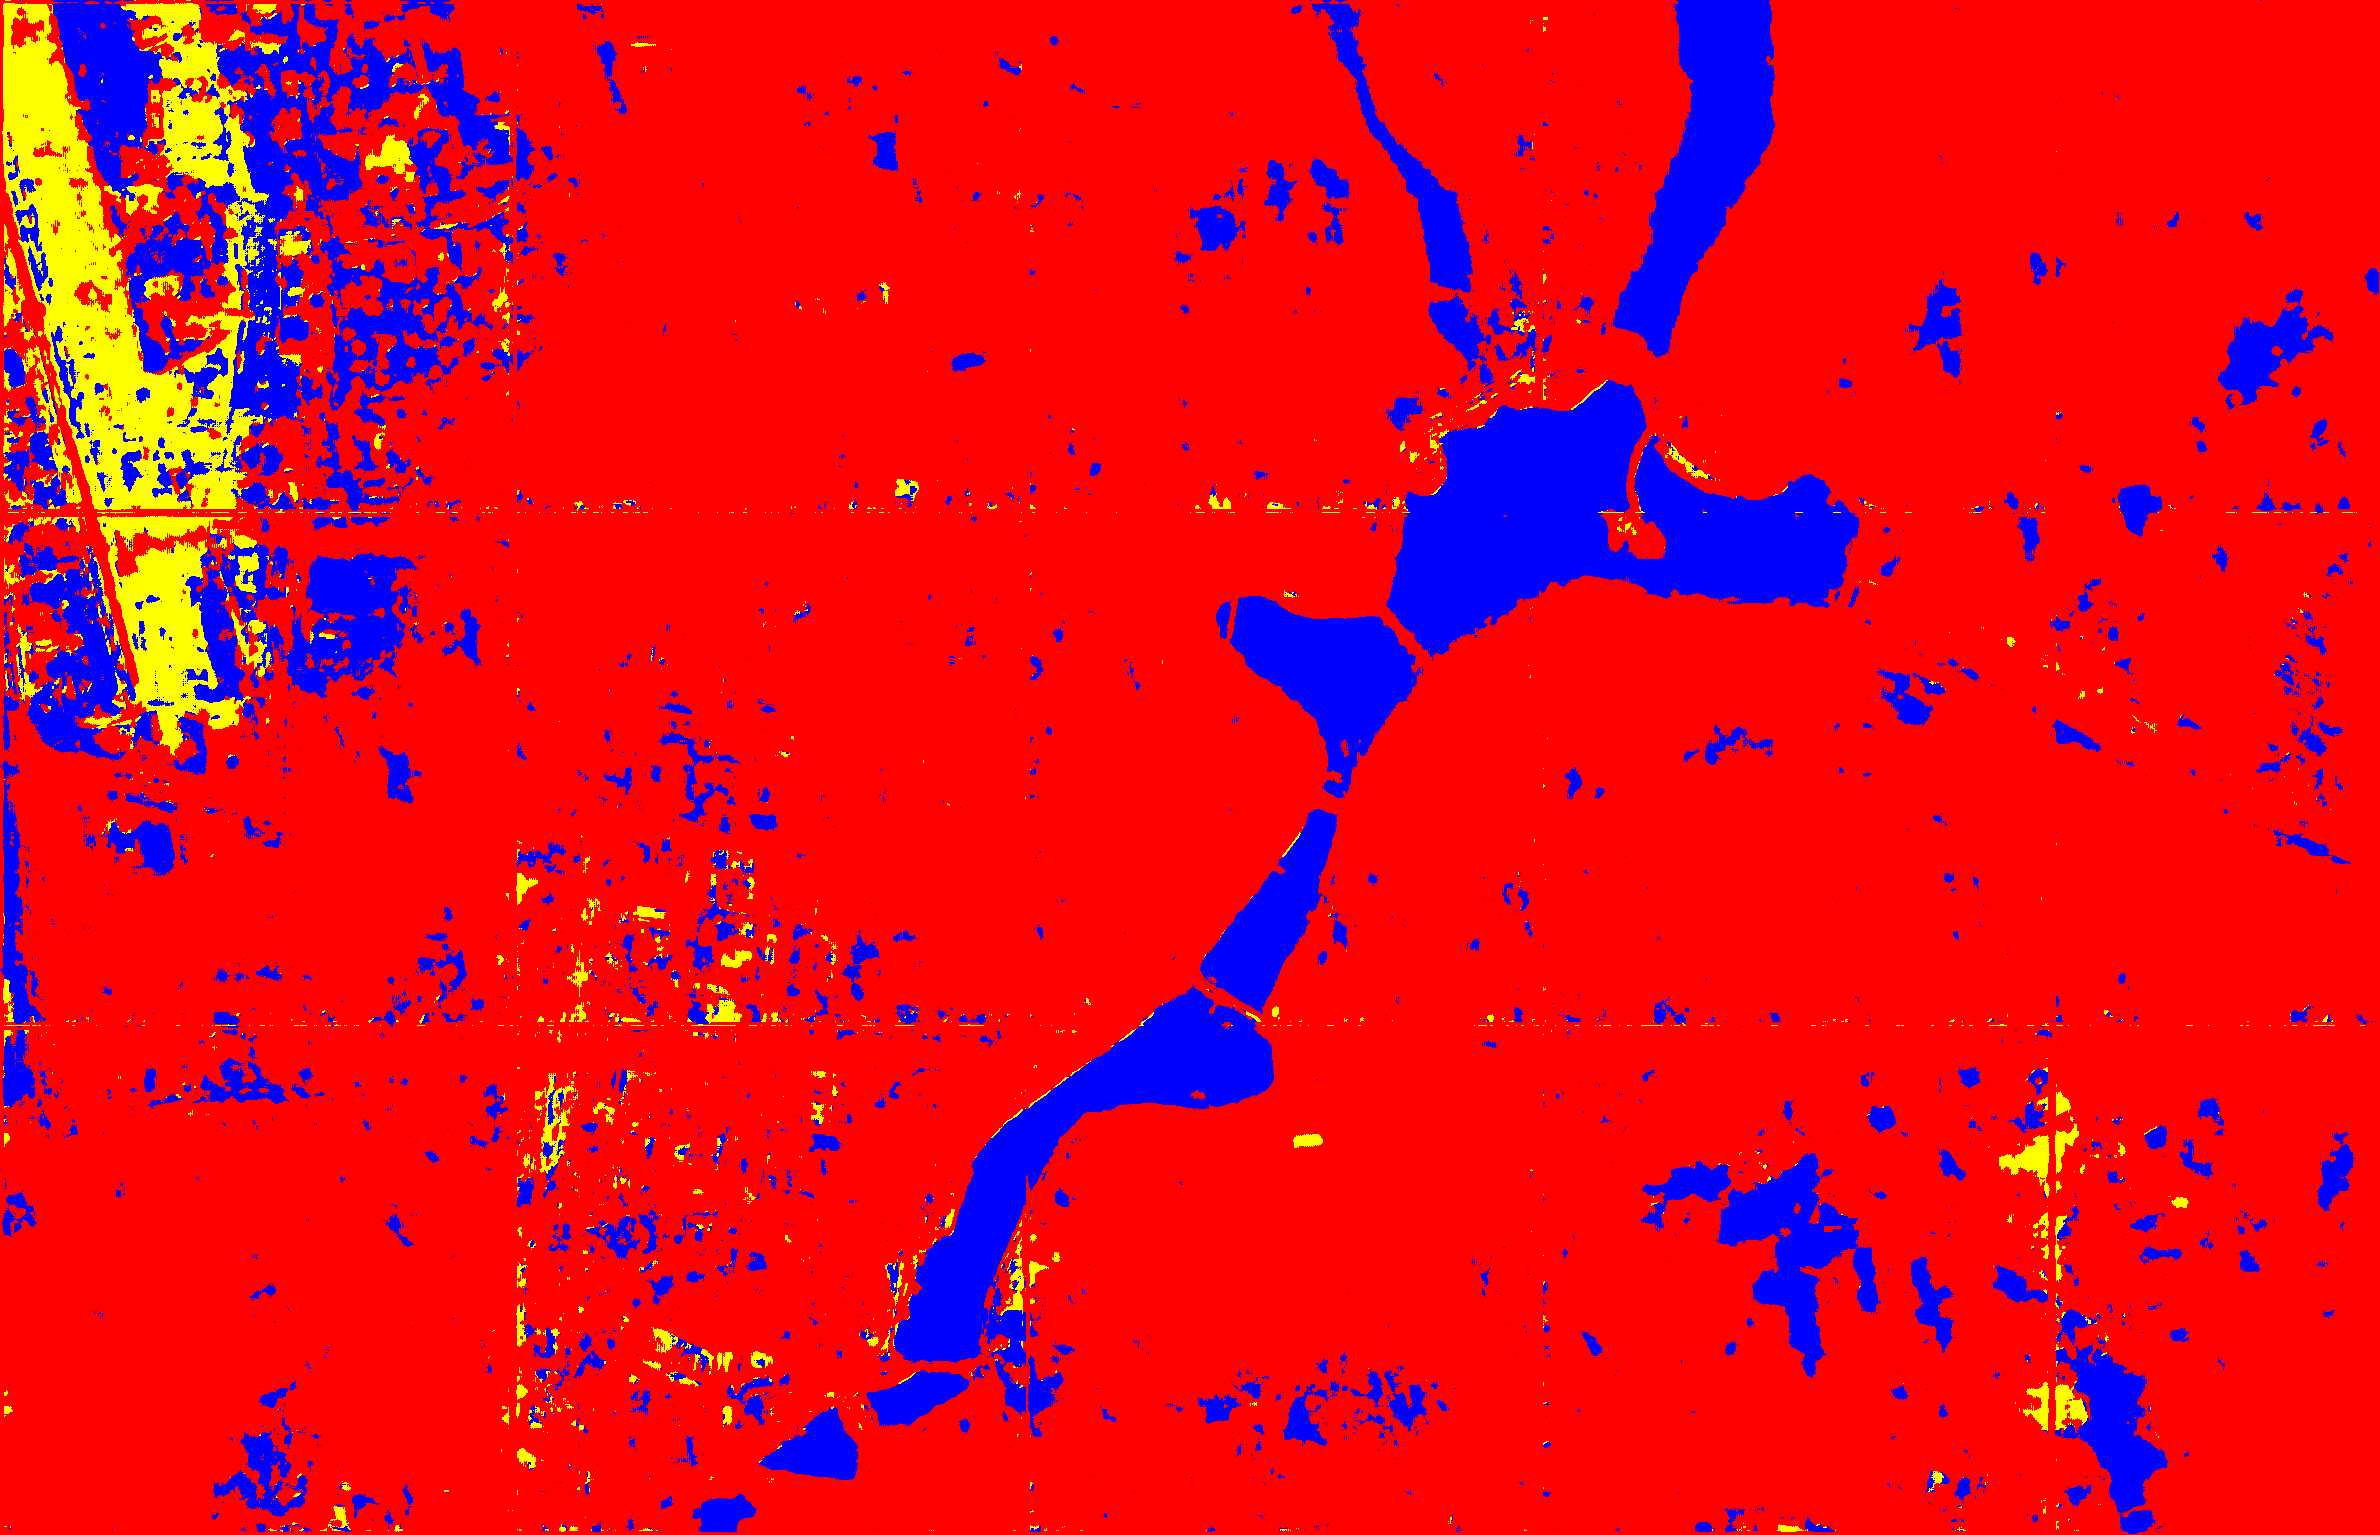

In [19]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
# from patchify import patchify, unpatchify
from torch.utils.data import Dataset, DataLoader
from UNet_LULC.UNet.unet.unet_model import UNet


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=3, n_classes=6, bilinear=False)

# Wrap the model with DataParallel to use multiple GPUs
if torch.cuda.device_count() > 1:
    # print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model.to(device)

checkpoint = torch.load(
    '/opt/models/unet/best_model3.pth', weights_only=False)
# checkpoint = torch.load(
#     'UNet_LULC/checkpoints/best_model.pth', weights_only=False)

# Adjust for multi-GPU loading if needed
if torch.cuda.device_count() > 1:
    new_state_dict = {}
    for key, value in checkpoint["model_state_dict"].items():
        new_key = "module." + \
            key if not key.startswith("module.") else key
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(checkpoint["model_state_dict"])

# def make_patches(image: Image.Image, patch_size: int) -> tuple[Image.Image, np.ndarray, tuple[int, ...]]:
#     # Nearest size which is patchable
#     size_x = (image.size[0] // patch_size) * patch_size
#     size_y = (image.size[1] // patch_size) * patch_size

#     image = image.crop((0, 0, size_x, size_y))
#     image_array = np.asarray(image)
#     image_size = image_array.shape
#     patch_images = patchify(image_array, patch_size=(
#         patch_size, patch_size, 3), step=patch_size)
#     # image = unpatchify(patch_images, image_size)
#     # image = Image.fromarray(image)

#     # x, y, _, a, b, c = patch_images.shape

#     # patch_images = patch_images.reshape(x, y, a, b, c)

#     return image, patch_images, image_size


def make_patches(image: np.ndarray, patch_size: int) -> tuple[np.ndarray, tuple[int, int]]:
    """
    Splits a PIL image into patches of size (patch_size, patch_size),
    zero-padding the remaining parts if needed.

    Args:
        image (PIL.Image.Image): Input image.
        patch_size (int): Size of each patch (square).

    Returns:
        numpy.ndarray: Array of patches with shape 
        (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, 3)
    """
    # image = image.convert('RGB')
    image_size = image.shape[1], image.shape[0]
    # image_np = np.array(image)
    image_np = image
    h, w, c = image_np.shape

    num_patches_vertical = (h + patch_size - 1) // patch_size
    num_patches_horizontal = (w + patch_size - 1) // patch_size

    patches = np.zeros(
        (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, c),
        dtype=image_np.dtype
    )

    for i in range(num_patches_vertical):
        for j in range(num_patches_horizontal):
            y_start = i * patch_size
            x_start = j * patch_size
            patch = image_np[y_start:y_start +
                             patch_size, x_start:x_start + patch_size]

            # Handle padding if needed
            padded_patch = np.zeros(
                (patch_size, patch_size, c), dtype=image_np.dtype)
            padded_patch[:patch.shape[0], :patch.shape[1], :] = patch

            patches[i, j, 0] = padded_patch

    return patches, image_size


def unpatchify(patches: np.ndarray, original_size: tuple[int, int]) -> np.ndarray:
    """
    Reconstructs the original image from patches.

    Args:
        patches (numpy.ndarray): Array of patches with shape 
            (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, 3)
        original_height (int): Height of the original image.
        original_width (int): Width of the original image.

    Returns:
        PIL.Image.Image: Reconstructed image.
    """
    original_width, original_height = original_size
    num_patches_vertical, num_patches_horizontal, _, patch_size, _, _ = patches.shape

    # Calculate full reconstructed size with padding
    full_height = num_patches_vertical * patch_size
    full_width = num_patches_horizontal * patch_size

    # Create an empty array to hold the reconstructed (possibly padded) image
    reconstructed = np.zeros((full_height, full_width, 3), dtype=patches.dtype)

    # Place each patch back into the image
    for i in range(num_patches_vertical):
        for j in range(num_patches_horizontal):
            y_start = i * patch_size
            x_start = j * patch_size
            reconstructed[y_start:y_start + patch_size,
                          x_start:x_start + patch_size] = patches[i, j, 0]

    # Remove any padding to match the original image size
    reconstructed_cropped = reconstructed[:original_height, :original_width]

    return reconstructed_cropped


def decode_segmap(image: np.ndarray, nc=6) -> np.ndarray:
    # 0=Unrecognized
    # 1=Farmland, 2=Water, 3=Forest, 4=Built-Up, 5=Meadow
    label_colors = np.array(
        # [(0, 0, 0), (0, 255, 255), (255, 0, 0), (0, 0, 255), (0, 255, 0), (255, 255, 0)])
        [(0, 0, 0), (0, 255, 0), (0, 0, 255),
         (0, 255, 255), (255, 0, 0), (255, 255, 0)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


class LULCDataset(Dataset):
    def __init__(self, images, transform=None, gt_transform=None):
        self.transform = transform
        self.gt_transform = gt_transform

        self.images = images.transpose((0, 3, 1, 2))

        # self.imdb = []
        # for img in os.listdir(self.datadir+'/images'):
        #     image_name = img.split('.')[0]
        #     ext_name = img.split('.')[-1]
        #     img_path = os.path.join(self.datadir, 'images', img)
        #     gt_path = os.path.join(self.datadir, 'gts',
        #                            image_name + '_gt.' + ext_name)
        #     self.imdb.append((img_path, gt_path))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]
        # img_path, gt_path = self.imdb[idx]

        # # Load images
        # image = Image.open(img_path).convert("RGB")
        # gt_image = Image.open(gt_path).convert("L")  # Assuming GT is grayscale

        # # Apply transformations if provided
        # if self.transform:
        #     image = self.transform(image)

        # label = np.array(gt_image)
        # # print(np.unique(label))

        # label = torch.LongTensor(label)

        # return image, label


def predict(image: np.ndarray, patch_size: int = 513) -> tuple[Image.Image, Image.Image]:
    # i_width, i_height = image.size
    # image = image.crop((0, 0,
    #                     i_width // patch_size * patch_size,
    #                     i_height // patch_size * patch_size))
    image = image[:, :, :3]
    original_image = image
    # print('image shape', image[:, :, :3].shape)
    patch_images, image_size = make_patches(image, patch_size)
    # print('patch image shape', patch_images.shape)
    # print(patch_images[0, 0, 0, 0, 0, :])
    size_y, size_x, _, p_s_1, p_s_2, channels = patch_images.shape
    patch_images = patch_images.reshape(
        size_x * size_y, p_s_1, p_s_2, channels)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                                         std=[0.229, 0.224, 0.225])
    ])

    dataset = LULCDataset(
        patch_images, transform=transform)

    loader = DataLoader(
        dataset, batch_size=4, shuffle=False, num_workers=4)

    # outputs = []

    # with torch.no_grad():
    #     for batch_images in loader:
    #         model.eval()
    #         batch_images = batch_images.to(device=device, dtype=torch.float32)
    #         print(batch_images.shape)
    #         batch_output = model(batch_images)
    #         batch_output = batch_output.detach().max(
    #             dim=1)[1].cpu().numpy()
    #         print(batch_output.shape)

    #         outputs.append(batch_output)

    # outputs = np.concatenate(outputs, axis=0).reshape(
    #     size_y, size_x, 1, p_s_1, p_s_2, channels)
    # print(outputs.shape)

    output_images = []
    count_array = np.zeros(6, dtype=np.int_)

    # for index, image in enumerate(patch_images):
    model.eval()
    with torch.no_grad():
        for batch_images in loader:

            # image = torchvision.transforms.functional.to_tensor(
            #     image).to(device)
            # image = torchvision.transforms.functional.normalize(
            #     image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).reshape(1, channels, patch_size, patch_size)
            # # image = image.to(device, dtype=torch.float32)
            # image = image.to(dtype=torch.float32)
            
            batch_images = batch_images.to(device).to(torch.float32)

            output = model(batch_images)
            print('raw', output.shape)
            output = output.detach().max(dim=1)[1].cpu().numpy()
            print('pred', output.shape)
    #         output = output.detach().max(dim=1)[1].cpu().numpy().squeeze(axis=0)
    #         # print('output:', output.shape)
            unique, counter = np.unique(output, return_counts=True)
            print(unique, counter)
            count_temp = np.zeros(6, dtype=np.int_)

            count_temp[unique] = counter

            count_array += count_temp
    #         # print(uni, counter)
    #         # count_array += np.pad(counter,
    #         #                       (0, count_array.size - counter.size), 'constant')
    #         # print('counter', counter)
    #         # print('count_array', count_array)
            for output_item in output:
                output_item = decode_segmap(output_item)
                output_item = Image.fromarray(output_item)
                output_images.append(output_item)

    output_images = np.stack(output_images, axis=0).reshape(
        size_y, size_x, 1, p_s_1, p_s_2, channels)
    # # print(output_images.shape)

    output_image = unpatchify(output_images, image_size)
    # # print(output_image.shape)
    img = Image.fromarray(output_image)
    # # width, height = img.size
    # # image = image.crop((0, 0, width, height))
    # # output.save('final_unet.png')

    labels = ['Farmland',
              'Water', 'Forest', 'Built-Up', 'Meadow']
    colors = ['0, 255, 0', '0, 0, 255',
              '0, 255, 255', '255, 0, 0', '255, 255, 0']
    # # print(count_array)
    area = [f'{val * 4.92e-6:,.2f}' for val in count_array[1:]]
    max_pixel = np.sum(count_array[1:]) or 1
    # # print(max_pixel)
    count_array = [f'{val / max_pixel * 100:.2f}%' for val in count_array[1:]]
    table = list(zip(labels, list(count_array), area, colors))
    # # print(count_array)

    # torch.cuda.empty_cache()

    return Image.fromarray(original_image), img, table
    # return table


image = Image.open(
    # '/opt/datasets/unet/BingRGB/test/images/patch_00184.png')
    'trash/input_image_123.png')
image = predict(np.asarray(image))
    
image[1]